In [1]:
%load_ext autoreload
%autoreload 2
%cd C:\MAD4AG
%matplotlib inline

C:\MAD4AG


In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import collections
import geopandas
import folium
from folium.plugins import HeatMapWithTime
import warnings

warnings.filterwarnings('ignore')

C:\Users\aglar\AppData\Local\anaconda3\envs\pycharm\lib\site-packages\geopandas\_compat.py:115: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [3]:
file_name = f'./dbs/intermediate/stops.parquet'

#Read each batchs file
df = pd.read_parquet(file_name)

In [4]:
print('The number of stops: ',len(df))
df = df[df.holiday_s != 1]
df = df[df.weekday_s == 1]
df = df.drop(['holiday_s', 'weekday_s'], axis=1)

print('The number of stops in weekday and non-holiday: ', len(df))


The number of stops:  29006512
The number of stops in weekday and non-holiday:  13453097


### repeat data points based on stay duration.
### e.g., if stay longer 30 min, make 2 data points

In [5]:
individual = df.copy()

In [6]:
individual['dur_rp'] = (individual['dur'] / 30) + 1
individual['dur_rp'] = individual['dur_rp'].astype(int)

In [7]:
individual = pd.DataFrame(np.repeat(individual.values, individual['dur_rp'].tolist(), axis=0),  columns=individual.columns)

### grouping and auto increment in index based stay

In [8]:
individual['stay_seq'] = individual.groupby(['uid', 'seq']).cumcount()

In [9]:
individual['timestamp'] = pd.to_datetime(individual['localtime']) + (pd.Timedelta(minutes=30) * individual['stay_seq'])

In [10]:
individual['hour'] = individual['timestamp'].dt.hour

In [11]:
#Hours with higher than 0.8 frequency of being at home in the survey data.

nighthours = (0,1,2,3,4,5,6,7,19,20,21,22,23,24)



In [12]:
# individual_gr = individual[individual.hour.isin(nighthours)]
#
# individual_gr = individual_gr.groupby(['uid','cluster'])['hour'].apply(list).to_frame('timestamp_sum')
# individual_gr.reset_index(inplace=True)

# tqdm.pandas()
# individual_gr['timestamp_sum']= individual_gr['timestamp_sum'].progress_apply(lambda x: collections.Counter(x))

In [13]:
# print('Hours of the day: ',individual_gr['timestamp_sum'].loc[0].keys())
# print('The number of repetition: ',individual_gr['timestamp_sum'].loc[0].values())

### number of visit for each cluster during night hours

In [14]:
df_night_visit = individual[['uid','cluster','localtime','hour']][individual.hour.isin(nighthours)]

df_night_visit['night_visits']= df_night_visit['localtime'].dt.strftime('%m-%d')

df_night_visit = df_night_visit.groupby(['uid','cluster'])['night_visits'].nunique().reset_index()

In [15]:
#clusters_2night_stay = df_night_visit[df_night_visit.night_visits>=2]

In [16]:
individual = pd.merge(individual, df_night_visit, on=['uid', 'cluster'], how='left')

In [17]:
#individual =  individual[individual.night_visits>=2]

In [18]:
#aaa = individual.head(1000)

### filter data points by having less than 2 night stay at the cluster and day time

In [19]:
#df_h = individual[individual.hour.isin(nighthours)]
df_h = individual[(individual.hour.isin(nighthours))&(individual.night_visits>=2)]

df_h = df_h.groupby(['uid','cluster'])['dur'].agg(['sum','count']).reset_index()

In [20]:
# df_h = pd.merge(df_h, individual_gr[['uid','cluster','timestamp_sum']], on=['uid','cluster'], how='left')

In [21]:
df_h = pd.merge(df_h, individual[['uid','cluster','ANDAMAL_1']].drop_duplicates(), on=['uid','cluster'], how='left')

In [22]:
df_h.rename({'count':'stops', 'sum':'total_duration' }, axis=1,inplace=True)

In [23]:
individual['hour_weight'] = 0

home_frequency = pd.read_csv('Master Thesis/Master Thesis Colab/DataFolder/Cag_activityTypefreBytime.csv')

home_frequency = home_frequency.iloc[0, 1:25].values.tolist()

for hour in range(0,24):
    individual['hour_weight'][individual['hour']== hour] = home_frequency[hour]

individual = individual[individual.hour.isin(nighthours)]
individual = individual.groupby(['uid','cluster'])['hour_weight'].sum().reset_index()

individual.rename({'hour_weight':'score' }, axis=1,inplace=True)

df_h = pd.merge(df_h, individual[['uid','cluster','score']], on=['uid','cluster'], how='left')

In [24]:
df_h= df_h.sort_values(['uid','score'], ascending=False)


#df_h = df_h[df_h['stops'] >= 10]
df_h = df_h[df_h['total_duration'] >= 300] #Note, do not change the outcome a lot. So most users that have 5 stops have 5 hours duration.


df_h = df_h.groupby('uid').head(2)
#df_h['ANDAMAL_1'].value_counts(normalize=True)

df_h.to_parquet(f'./dbs/intermediate/home_inference.parquet')

### Score distribution of inferred home locations

<AxesSubplot:ylabel='Frequency'>

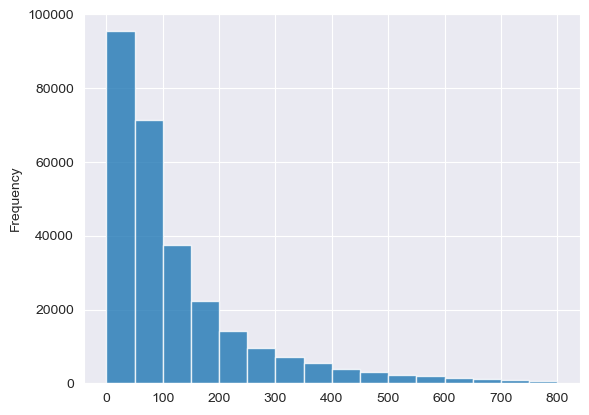

In [25]:
df_h_1 = df_h.groupby('uid').head(1)

df_h_1['score'][df_h_1['score']<=800].plot.hist(bins=range(0,850,50), alpha=0.8)


### Add building metadata to the extracted house location and show the distribution of building types

In [26]:
building_metadata = pd.read_csv(f'./dbs/building_purpose_codes.csv', encoding='ISO-8859-1', sep = ';')

In [27]:

home_dist = pd.DataFrame(df_h_1['ANDAMAL_1'].value_counts(normalize=True)*100).reset_index().rename(columns={'ANDAMAL_1':'share(%)'})
home_dist = pd.merge(home_dist, building_metadata, left_on='index', right_on='Code', how='left')

home_dist['Purpose of building'][home_dist['index']==0]='no_building'


home_dist = home_dist.groupby('Purpose of building')['share(%)'].sum().reset_index().sort_values(by=['share(%)'], ascending=False)

home_dist

,Purpose of building,share(%)
5,Residential,73.167113
4,Public,9.848760
0,Activity,7.902978
2,Industrial,3.470305
6,no_building,3.272695
3,Other building,2.228286
1,Agricultural,0.109863


In [28]:
print("Data contains %s devices in weekdays-non holidays."%(len(df.uid.unique())))
print("%s devices' home location couldn't detected."%(len(df.uid.unique())-len(df_h.groupby('uid').head(1))))

Data contains 322452 devices in weekdays-non holidays.
42102 devices' home location couldn't detected.


### devices having  most likely two house location

In [29]:
df_h_two_house = df_h[df_h.duplicated(subset=['uid']) | df_h.duplicated(subset=['uid'], keep='last')]

df_h_two_house = df_h_two_house.sort_values(by=['uid', 'score'])

In [30]:
# df_h_two_house['score_dif']= 0.0
#
#
# res = pd.DataFrame(df_h_two_house['score'].values[1::2] - df_h_two_house['score'].values[::2], columns=['score'])
# #
# df_h_two_house['score_dif'].values[::2] = res.score
# df_h_two_house['score_dif'].values[1::2] = res.score


df_h_two_house['score_per_dif']= 0.0


percent_dif = pd.DataFrame(( 1- (df_h_two_house['score'].values[::2]/df_h_two_house['score'].values[1::2])) , columns=['percent_dif'])

df_h_two_house['score_per_dif'].values[::2] = percent_dif.percent_dif
df_h_two_house['score_per_dif'].values[1::2] = percent_dif.percent_dif


df_h_two_house = df_h_two_house[(df_h_two_house.score > 100)& (df_h_two_house.score_per_dif < 0.1)]


In [31]:
print("%s devices most likely have two home locations."%(len(df_h_two_house.uid.unique())))

2095 devices most likely have two home locations.
